# 1. Data Processing

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import random

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

from collections import Counter

import torch
import torch.nn as nn

from torchinfo import summary

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch.optim as optim

import ssl
import certifi
import urllib.request

from torchvision import models
import torch.nn as nn

from plotly import graph_objects as go

import torch.nn.functional as F
import numpy as np

In [ ]:
# once split the train/validation, no need to run it again
source_dir = './archive/raw-img'
target_dir = './animals10'

train_test_ratio = 0.8

for split in ['train', 'validation']:
    split_path = os.path.join(target_dir, split)
    os.makedirs(split_path, exist_ok=True)

for class_name in os.listdir(source_dir):
    if not c.startswith('.'):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', 'jpeg', '.png'))]
        random.shuffle(images)

        split_index = int(len(images)*train_test_ratio)
        train_images = images[:split_index]
        val_images = images[split_index:]

        for split, split_images in [('train', train_images), ('validation', val_images)]:
            split_class_dir = os.path.join(target_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(class_path, img_name)
                dst = os.path.join(split_class_dir, img_name)
                shutil.copy2(src, dst)

# generate a test set
source_dir = './animals10/validation'
target_dir = './animals10/test'
os.makedirs(target_dir, exist_ok=True)

num_images = 5
animal_class = [x for x in os.listdir(source_dir) if x!= '.DS_Store']

for ac in animal_class:
    src = os.path.join(source_dir, ac)
    
    images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', 'jpeg', '.png'))]
    random.shuffle(images)

    test_images = images[:num_images]

    for img in test_images:
        src_img = os.path.join(src, img)
        tgt_img = os.path.join(target_dir, ac+ '_' + img)
        shutil.copy2(src_img, tgt_img)

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Random color adjustments
    transforms.Resize([100,100]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]),  ## is normalization really needed?
])

# Load dataset
train_dataset = ImageFolder(root="./animals10/train", transform=transform)
val_dataset = ImageFolder(root="./animals10/validation", transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36470586..0.70980394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.5294118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.16078436].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62352943..-0.027450979].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64705884..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.70980394]

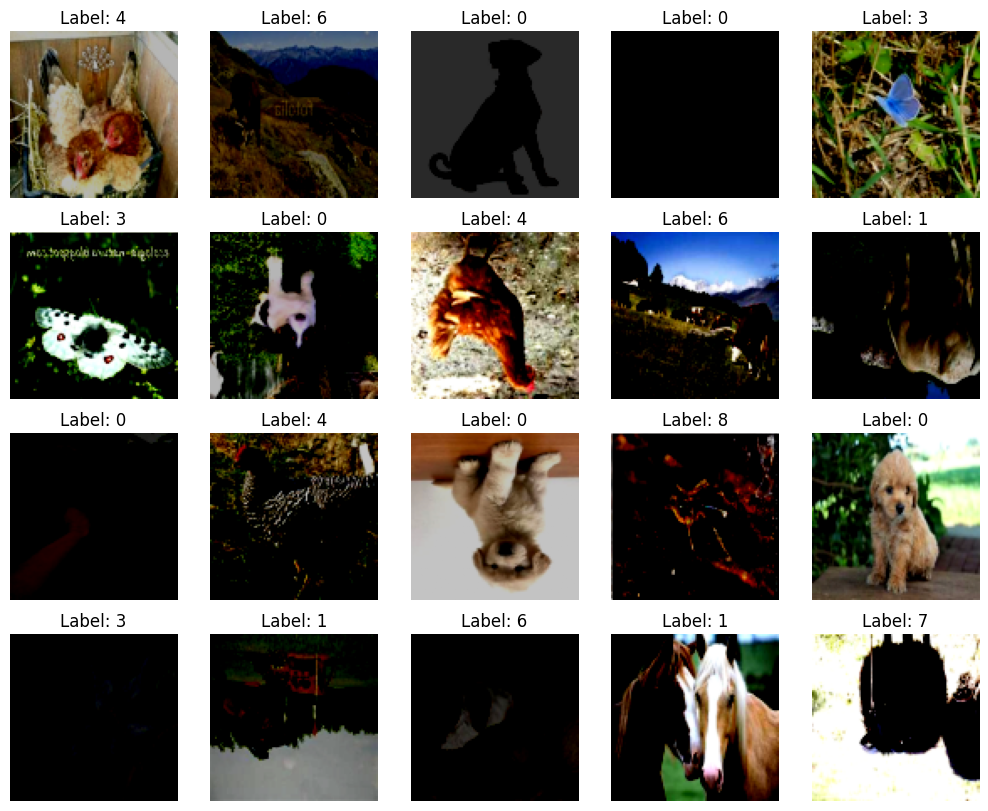

In [ ]:
# Get a batch of images
images, labels = next(iter(train_loader))

# Convert tensor to numpy for visualization
fig, ax = plt.subplots(4, 5, figsize=(12.5, 10))
for i in range(20):
    img = images[i].permute(1, 2, 0).numpy()
    ax[i // 5, i % 5].imshow(img)
    ax[i // 5, i % 5].set_title(f"Label: {labels[i]}")
    ax[i // 5, i % 5].axis("off")

plt.show()

## 1.1 Check label imabalance

In [ ]:
label_count = {i: 0 for i in range(10)}
for inputs, labels in train_loader:
    batch_count = Counter(labels.tolist())
    for i in range(10):
        label_count[i] += batch_count[i]

total = sum(label_count.values())
label_ratio = {i: label_count[i]/total for i in range(10)}
print(label_ratio)

{0: 0.18578660808100106, 1: 0.10020059222466329, 2: 0.05521062183589646, 3: 0.08066673034673799, 4: 0.11834941255134206, 5: 0.06371191135734072, 6: 0.07125799980895979, 7: 0.06953863788327443, 8: 0.18416276626229822, 9: 0.07111471964848601}


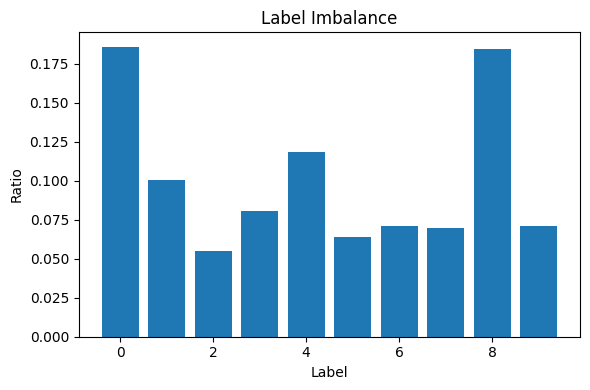

In [185]:
# Create bar plot
plt.figure(figsize=(6, 4))
plt.bar(list(label_ratio.keys()), list(label_ratio.values()))
plt.xlabel('Label')
plt.ylabel('Ratio')
plt.title('Label Imbalance')
plt.tight_layout()
plt.show()

# 2. Model Architecture

In [ ]:
class CNNWithPooling(nn.Module):
    def __init__(self):
        super(CNNWithPooling, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding="same")
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same")
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding="same")
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same")
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 6 * 6, 10)  # Adjust the size based on input shape
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = torch.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
# Print model summary
summary(model_pooling, input_size=(1, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CNNWithPooling                           [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 100, 100]         896
├─BatchNorm2d: 1-2                       [1, 32, 100, 100]         64
├─MaxPool2d: 1-3                         [1, 32, 50, 50]           --
├─Conv2d: 1-4                            [1, 64, 50, 50]           18,496
├─BatchNorm2d: 1-5                       [1, 64, 50, 50]           128
├─MaxPool2d: 1-6                         [1, 64, 25, 25]           --
├─Conv2d: 1-7                            [1, 64, 25, 25]           36,928
├─BatchNorm2d: 1-8                       [1, 64, 25, 25]           128
├─MaxPool2d: 1-9                         [1, 64, 12, 12]           --
├─Conv2d: 1-10                           [1, 128, 12, 12]          73,856
├─BatchNorm2d: 1-11                      [1, 128, 12, 12]          256
├─MaxPool2d: 1-12                        [1, 128, 6, 6]            --

# 3. Model Training + 4. Model Evaluation

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.should_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    """
    Function to train a PyTorch model with training and validation datasets.
    
    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).
    
    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """
    
    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1': [], 'weighted avg': [], 'confusion matrix': []}

    # apply early stoppping
    early_stopper = EarlyStopping(patience = 5, min_delta=0)
    
    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels.long())  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters
            
            total_loss += loss.item()  # Accumulate batch loss
            
            # correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

            # Get predicted class indices
            _, predicted = torch.max(outputs, dim=1)  # shape: [batch_size]
            # Compare with true labels
            correct += (predicted == labels).sum().item()
        
        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        val_preds = []
        val_labels = []
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels.long())  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                # val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions
                _, val_predicted = torch.max(outputs, dim=1)
                val_correct += (val_predicted==labels).sum().item()
                
                # prepare classification reports
                val_preds.extend(val_predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # classification report
        cr = classification_report(val_labels, val_preds, digits=4, output_dict=True)
        wavg = cr['weighted avg']
        mavg = cr['macro avg']
        # confusion matrix
        cm = confusion_matrix(val_labels, val_preds)
        
        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(cr['macro avg']['f1-score'])
        history['weighted avg'].append(wavg)
        history['confusion matrix'].append(cm)
        
        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {mavg['f1-score']:.4f}")
        # print classification report for validation set
        print(f"    Weighted avg -- Precision: {wavg['precision']:.4f}, Recall: {wavg['recall']:.4f}, F1-score: {wavg['f1-score']:.4f}")
        print(f"    Macro avg    -- Precision: {mavg['precision']:.4f}, Recall: {mavg['recall']:.4f}, F1-score: {mavg['f1-score']:.4f}")

        early_stopper(val_loss)
        if early_stopper.should_stop:
            print('Early stopping triggered.')
            break
    
    return history  # Return training history

In [ ]:
# take into account data imbalance
# Instantiate and train model with pooling
model_pooling = CNNWithPooling()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.tensor([
    total / label_count[i] for i in range(len(label_count))
], dtype=torch.float)

criterion = nn.CrossEntropyLoss(weight = weights.to(device))
optimizer_pooling = optim.Adam(model_pooling.parameters(), lr=0.001)
history_pooling = train(model_pooling, train_loader, val_loader, criterion, optimizer_pooling, epochs=40)

Epoch [1/40], Loss: 2.1186, Acc: 0.2672, Val Loss: 1.8888, Val Acc: 0.3375, Val F1: 0.3292
    Weighted avg -- Precision: 0.4861, Recall: 0.3376, F1-score: 0.3564
    Macro avg    -- Precision: 0.4168, Recall: 0.3569, F1-score: 0.3292
Epoch [2/40], Loss: 1.6624, Acc: 0.4278, Val Loss: 1.7226, Val Acc: 0.4367, Val F1: 0.3847
    Weighted avg -- Precision: 0.4788, Recall: 0.4368, F1-score: 0.4281
    Macro avg    -- Precision: 0.4379, Recall: 0.3856, F1-score: 0.3847
Epoch [3/40], Loss: 1.4812, Acc: 0.4942, Val Loss: 1.3858, Val Acc: 0.5007, Val F1: 0.4909
    Weighted avg -- Precision: 0.6001, Recall: 0.5008, F1-score: 0.5108
    Macro avg    -- Precision: 0.5408, Recall: 0.5228, F1-score: 0.4909
Epoch [4/40], Loss: 1.3422, Acc: 0.5434, Val Loss: 1.2726, Val Acc: 0.5760, Val F1: 0.5494
    Weighted avg -- Precision: 0.6070, Recall: 0.5761, F1-score: 0.5820
    Macro avg    -- Precision: 0.5557, Recall: 0.5634, F1-score: 0.5494
Epoch [5/40], Loss: 1.2244, Acc: 0.5835, Val Loss: 1.2633, V

In [224]:
# Save model checkpoint 
checkpoint_path = "model_pooling.pth"
torch.save({
    'model_state_dict': model_pooling.state_dict(),
    'optimizer_state_dict': optimizer_pooling.state_dict(),
    'val_loss': history_pooling["val_loss"][-1],
}, checkpoint_path)

In [ ]:
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_pooling["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_pooling["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [225]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_pooling["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_pooling["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

# 5. Transfer Learning

## 5.1 Inception

In [ ]:
#
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.urlopen('https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth', context=ssl_context)

In [2]:
# Training function for a PyTorch model
def train_tr1(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    """
    Function to train a PyTorch model and evaluate it on a validation set.

    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - criterion: Loss function (e.g., CrossEntropyLoss for classification).
    - optimizer: Optimization algorithm (e.g., Adam, SGD).
    - epochs: Number of training epochs (default = 50).

    Returns:
    - history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store loss and accuracy values for each epoch
    # history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'val_f1': [], 'weighted avg': [], 'confusion matrix': []}
    early_stopper = EarlyStopping(patience = 2, min_delta=0.005)

    # Loop through the specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize loss and correct predictions
        
        # Training loop - iterate through batches in the training set
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            logit, aux_logit = model(inputs)  # Forward pass: Get predictions
            loss = criterion(logit, labels)  # Compute loss
            loss.backward()  # Backpropagation: Compute gradients
            optimizer.step()  # Update model parameters using optimizer
            
            total_loss += loss.item()  # Accumulate total loss
            correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions
        
        # Compute average loss and accuracy for the training set
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)
        
        # Validation phase (no gradient calculation needed)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        val_preds = []
        val_labels = []
        with torch.no_grad():  # Disable gradient calculation for efficiency
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                logit = model(inputs)  # Forward pass
                _, preds = torch.max(logit, 1) # extract predictions
                loss = criterion(logit, labels.data)  # Compute validation loss
                val_loss += loss.item()  # Accumulate validation loss
                val_correct += (logit.argmax(dim=1) == labels.data).sum().item()  # Count correct predictions

                # prepare classification reports
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Compute average loss and accuracy for the validation set
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # classification report
        cr = classification_report(val_labels, val_preds, digits=4, output_dict=True)
        wavg = cr['weighted avg']
        mavg = cr['macro avg']
        # confusion matrix
        cm = confusion_matrix(val_labels, val_preds)
        
        # Store training and validation metrics for analysis
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        history['val_f1'].append(cr['macro avg']['f1-score'])
        history['weighted avg'].append(wavg)
        history['confusion matrix'].append(cm)
        
        # Print progress after each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # print classification report for validation set
        print(f"    Weighted avg -- Precision: {wavg['precision']:.4f}, Recall: {wavg['recall']:.4f}, F1-score: {wavg['f1-score']:.4f}")
        print(f"    Macro avg    -- Precision: {mavg['precision']:.4f}, Recall: {mavg['recall']:.4f}, F1-score: {mavg['f1-score']:.4f}")

        early_stopper(val_loss)
        if early_stopper.should_stop:
            print('Early stopping triggered.')
            break
    
    return history  # Return training history


In [ ]:
# Resize to 299, 299 otherwise the model can't be trained
transform = transforms.Compose([
    #transforms.RandomRotation(180),  # Rotate image randomly
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),  # Random vertical flip
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Random color adjustments
    transforms.Resize([299,299]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5]), 
])

# Load dataset
train_dataset = ImageFolder(root="./animals10/train", transform=transform)
val_dataset = ImageFolder(root="./animals10/validation", transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True, drop_last=True)

In [18]:
# 
model_tr1 = models.inception_v3(weights="IMAGENET1K_V1")

num_classes = len(val_loader.dataset.classes)
model_tr1.fc = nn.Linear(model_tr1.fc.in_features, num_classes)

# Unfreeze last 30 layers for fine-tuning
fine_tune_at = len(list(model_tr1.children())) - 30
for param in list(model_tr1.parameters())[fine_tune_at:]:
    param.requires_grad = True

print(model_tr1)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [19]:
# Print model summary
summary(model_tr1, input_size=(1, 3, 299, 299))  # (batch_size, input_features)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [1, 10]                   3,326,696
├─BasicConv2d: 1-1                       [1, 32, 149, 149]         --
│    └─Conv2d: 2-1                       [1, 32, 149, 149]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 149, 149]         64
├─BasicConv2d: 1-2                       [1, 32, 147, 147]         --
│    └─Conv2d: 2-3                       [1, 32, 147, 147]         9,216
│    └─BatchNorm2d: 2-4                  [1, 32, 147, 147]         64
├─BasicConv2d: 1-3                       [1, 64, 147, 147]         --
│    └─Conv2d: 2-5                       [1, 64, 147, 147]         18,432
│    └─BatchNorm2d: 2-6                  [1, 64, 147, 147]         128
├─MaxPool2d: 1-4                         [1, 64, 73, 73]           --
├─BasicConv2d: 1-5                       [1, 80, 73, 73]           --
│    └─Conv2d: 2-7                       [1, 80, 73, 73]           5,

In [20]:
# train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion_tr1 = nn.CrossEntropyLoss()
criterion_tr1 = criterion_tr1.to(device)  # Move loss function to MPS

optimizer_tr1 = optim.Adam(model_tr1.parameters(), lr=0.0001)  # Smaller learning rate

history_tr1 = train_tr1(model_tr1, train_loader, val_loader, criterion_tr1, optimizer_tr1, epochs=5)

Epoch [1/5], Loss: 0.3501, Acc: 0.8965, Val Loss: 0.2028, Val Acc: 0.9391
    Weighted avg -- Precision: 0.9405, Recall: 0.9393, F1-score: 0.9395
    Macro avg    -- Precision: 0.9367, Recall: 0.9347, F1-score: 0.9352
Epoch [2/5], Loss: 0.1755, Acc: 0.9465, Val Loss: 0.1454, Val Acc: 0.9540
    Weighted avg -- Precision: 0.9547, Recall: 0.9542, F1-score: 0.9542
    Macro avg    -- Precision: 0.9519, Recall: 0.9509, F1-score: 0.9510
Epoch [3/5], Loss: 0.1392, Acc: 0.9573, Val Loss: 0.1390, Val Acc: 0.9580
    Weighted avg -- Precision: 0.9587, Recall: 0.9582, F1-score: 0.9582
    Macro avg    -- Precision: 0.9597, Recall: 0.9543, F1-score: 0.9567
Epoch [4/5], Loss: 0.1139, Acc: 0.9656, Val Loss: 0.1715, Val Acc: 0.9473
    Weighted avg -- Precision: 0.9506, Recall: 0.9475, F1-score: 0.9477
    Macro avg    -- Precision: 0.9516, Recall: 0.9368, F1-score: 0.9424
Epoch [5/5], Loss: 0.0906, Acc: 0.9722, Val Loss: 0.1693, Val Acc: 0.9456
    Weighted avg -- Precision: 0.9474, Recall: 0.9458,

In [22]:
history_tr1['weighted avg']

[{'precision': 0.9404582088078984,
  'recall': 0.9393129770992367,
  'f1-score': 0.9394751684231106,
  'support': 5240.0},
 {'precision': 0.9547130989731143,
  'recall': 0.9541984732824428,
  'f1-score': 0.9541808100949326,
  'support': 5240.0},
 {'precision': 0.9586753326361059,
  'recall': 0.958206106870229,
  'f1-score': 0.9581528370009622,
  'support': 5240.0},
 {'precision': 0.9506352032301616,
  'recall': 0.9475190839694656,
  'f1-score': 0.9476864880016462,
  'support': 5240.0},
 {'precision': 0.9473680886041062,
  'recall': 0.9458015267175572,
  'f1-score': 0.9458623414427365,
  'support': 5240.0}]

In [15]:
history_tr1['confusion matrix'][-1]

array([[926,   4,   6,   0,   9,  13,   6,   4,   2,   3],
       [ 16, 461,  19,   0,   6,   0,  13,   7,   2,   1],
       [  1,   0, 287,   0,   0,   0,   0,   2,   0,   0],
       [  3,   0,   3, 392,   2,   1,   0,   0,  22,   0],
       [ 12,   3,   2,   0, 590,   3,   2,   3,   3,   2],
       [ 11,   0,   0,   0,   0, 321,   0,   1,   0,   1],
       [  3,   1,  10,   1,   1,   0, 342,  16,   0,   0],
       [  7,   0,   7,   0,   8,   1,   4, 334,   1,   1],
       [  3,   0,   3,   4,   3,   2,   0,   1, 947,   2],
       [  6,   0,   2,   1,   3,   4,   1,   0,   0, 356]])

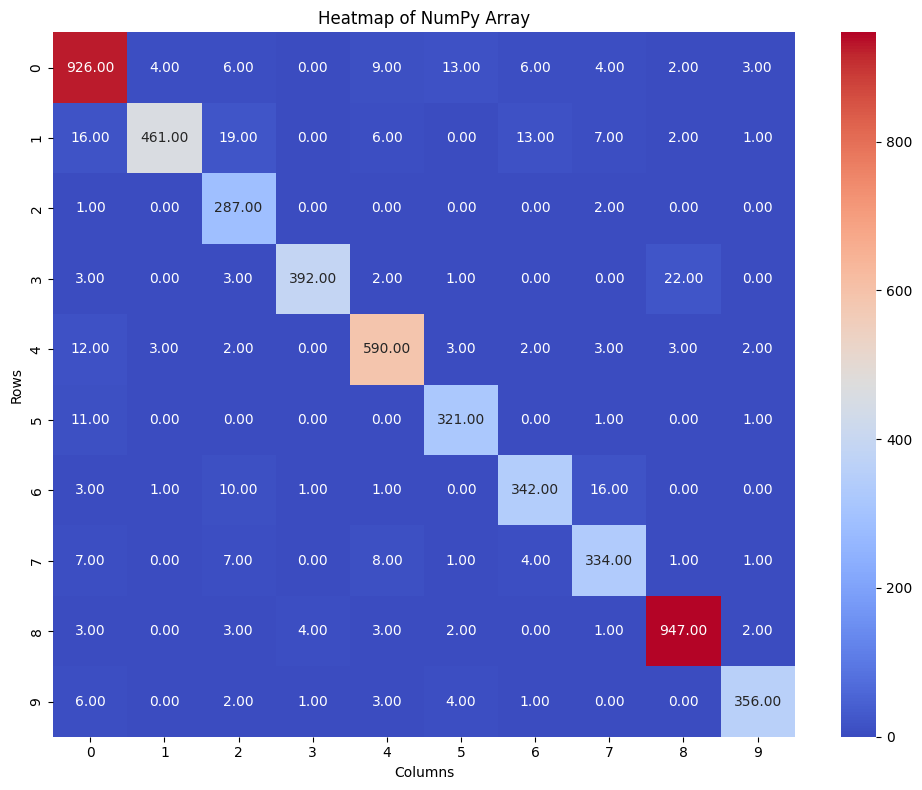

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(history_tr1['confusion matrix'][-1], annot=True, fmt=".2f", cmap="coolwarm")  
plt.title("Heatmap of NumPy Array")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

In [ ]:
# Save model checkpoint 
checkpoint_path = "app/model_inception.pth"
torch.save({
    'model_state_dict': model_tr1.state_dict(),
    'optimizer_state_dict': optimizer_tr1.state_dict(),
    'val_loss': history_tr1["val_loss"][-1],
    'weighted avg': history_tr1['weighted avg'],
    'confusion matrix': history_tr1['confusion matrix'],
    'class name': {val_loader.dataset.class_to_idx[k]:k for k in val_loader.dataset.class_to_idx}
}, checkpoint_path)

In [30]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

fig = go.Figure(data=[
                      go.Scatter(
                          y=history_tr1["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_tr1["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

In [ ]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history_tr1["accuracy"],
                          name="Training Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history_tr1["val_accuracy"],
                          name="Validation Accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val Al' \
    'ccuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()

# Load model and test the model

In [119]:
test_path = './animals10/test'
image_class = [x for x in os.listdir(test_path) if x!= '.DS_Store']

test_num = random.randint(0,9)
test_image_path = os.path.join(test_path, image_class[test_num])
test_images = [f for f in os.listdir(test_image_path) if f.lower().endswith(('.jpg', 'jpeg', '.png'))] 
selected_file = random.choice(test_images)

print(test_image_path, selected_file)

test_image = Image.open(os.path.join(test_image_path, selected_file)).convert("RGB")
test_tensor = transform(test_image).unsqueeze(0)


./animals10/test/mucca OIP-zTRwCiP1MA2gtrOUjhYBTgHaE8.jpeg


In [ ]:
model = models.inception_v3(weights="IMAGENET1K_V1")
model.fc = torch.nn.Linear(model.fc.in_features, 10)

checkpoint = torch.load("app/model_inception.pth", map_location=torch.device("cpu"), weights_only=False)
class_name = checkpoint['class name']
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [120]:
with torch.no_grad():
    output = model(test_tensor)
    prob = F.softmax(output, dim=1)
    pred_class = torch.argmax(prob, dim=1).item()
    pred_prob = prob[0][pred_class]
    pred_class_name = class_name[pred_class]

print(pred_class_name, pred_prob)

mucca tensor(0.9989)
